<a href="https://colab.research.google.com/github/Jonathan-Chia/mmm-research/blob/main/bayesian_mmm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian MMM

Let's now adjust our [Bayesian Linear Regression](https://colab.research.google.com/drive/1ZppqL9fUdPzqyL2FXa2EqFcKrzCgd28D?usp=sharing) for a time series, since MMM data is time series data, and add in the adstock and saturation.

In [1]:
!pip install pymc_marketing

In [2]:
from pymc_marketing.mmm import MMM, GeometricAdstock, LogisticSaturation
from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import xarray as xr

## Generate Data

First generate the dates.

In [3]:
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

# date range
min_date = pd.to_datetime("2018-04-01")
max_date = pd.to_datetime("2021-09-01")

df = pd.DataFrame(
    data={"date_week": pd.date_range(start=min_date, end=max_date, freq="W-MON")}
).assign(
    year=lambda x: x["date_week"].dt.year,
    month=lambda x: x["date_week"].dt.month,
    dayofyear=lambda x: x["date_week"].dt.dayofyear,
)

n = df.shape[0]
print(f"Number of observations: {n}")

Number of observations: 179


We will have 2 media channels - one that is always on such as search, and the other that is sent in bursts such as direct mail.

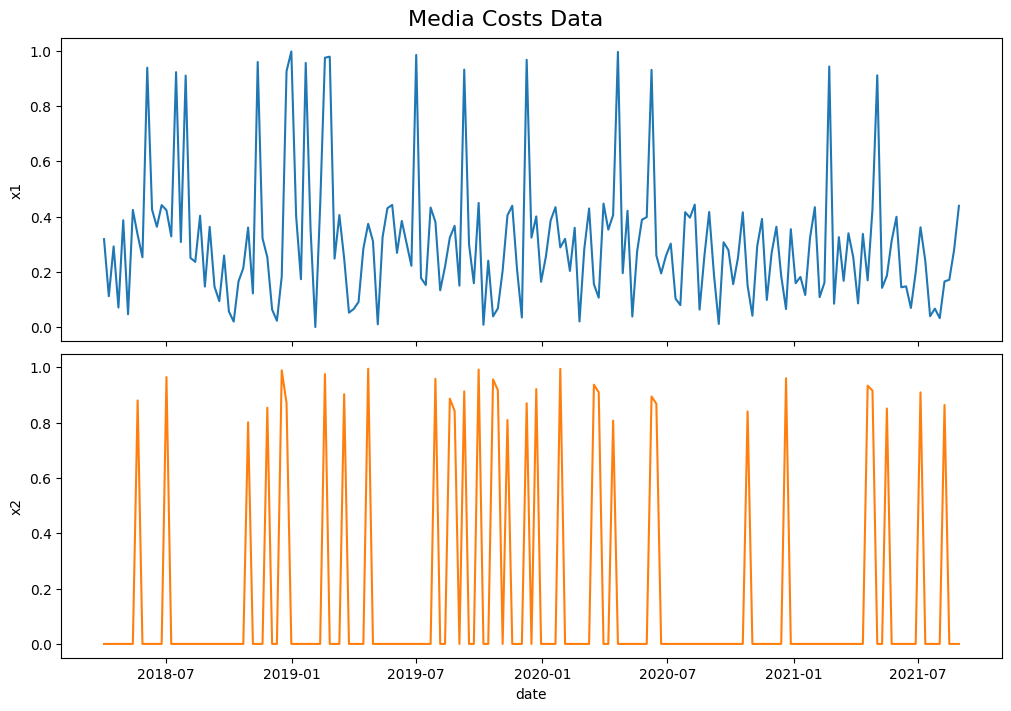

In [4]:
# media data
x1 = rng.uniform(low=0.0, high=1.0, size=n)
df["x1"] = np.where(x1 > 0.9, x1, x1 / 2)

x2 = rng.uniform(low=0.0, high=1.0, size=n)
df["x2"] = np.where(x2 > 0.8, x2, 0)


fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(10, 7), sharex=True, sharey=True, layout="constrained"
)
sns.lineplot(x="date_week", y="x1", data=df, color="C0", ax=ax[0])
sns.lineplot(x="date_week", y="x2", data=df, color="C1", ax=ax[1])
ax[1].set(xlabel="date")
fig.suptitle("Media Costs Data", fontsize=16);

In [5]:
# apply geometric adstock transformation
alpha1: float = 0.4
alpha2: float = 0.2

df["x1_adstock"] = (
    geometric_adstock(x=df["x1"].to_numpy(), alpha=alpha1, l_max=8, normalize=True)
    .eval()
    .flatten()
)

df["x2_adstock"] = (
    geometric_adstock(x=df["x2"].to_numpy(), alpha=alpha2, l_max=8, normalize=True)
    .eval()
    .flatten()
)

In [6]:
# apply saturation transformation
lam1: float = 4.0
lam2: float = 3.0

df["x1_adstock_saturated"] = logistic_saturation(
    x=df["x1_adstock"].to_numpy(), lam=lam1
).eval()

df["x2_adstock_saturated"] = logistic_saturation(
    x=df["x2_adstock"].to_numpy(), lam=lam2
).eval()

Here's the transformed media spend.

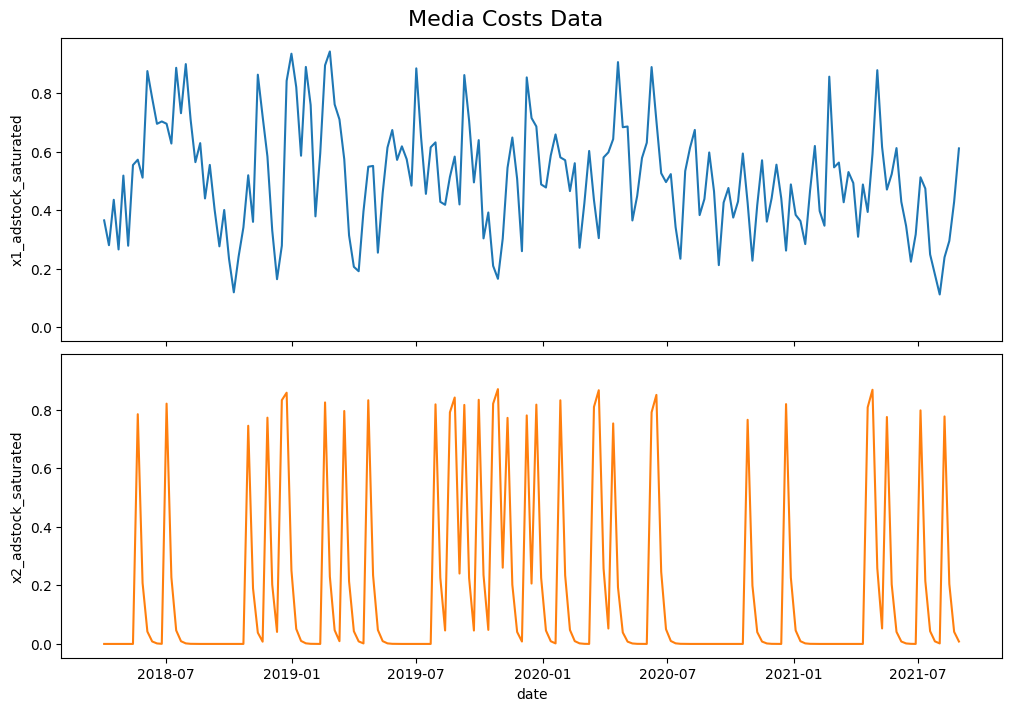

In [7]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(10, 7), sharex=True, sharey=True, layout="constrained"
)
sns.lineplot(x="date_week", y="x1_adstock_saturated", data=df, color="C0", ax=ax[0])
sns.lineplot(x="date_week", y="x2_adstock_saturated", data=df, color="C1", ax=ax[1])
ax[1].set(xlabel="date")
fig.suptitle("Media Costs Data", fontsize=16);

Also adding in some seasonality and trend.

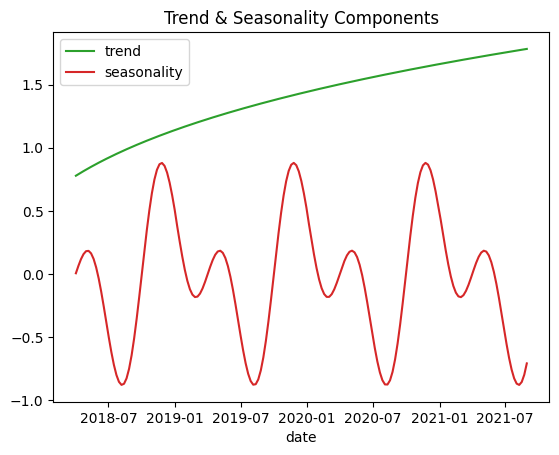

In [8]:
# add seasonality and trend
df["trend"] = (np.linspace(start=0.0, stop=50, num=n) + 10) ** (1 / 4) - 1

df["cs"] = -np.sin(2 * 2 * np.pi * df["dayofyear"] / 365.5)
df["cc"] = np.cos(1 * 2 * np.pi * df["dayofyear"] / 365.5)
df["seasonality"] = 0.5 * (df["cs"] + df["cc"])

fig, ax = plt.subplots()
sns.lineplot(x="date_week", y="trend", color="C2", label="trend", data=df, ax=ax)
sns.lineplot(
    x="date_week", y="seasonality", color="C3", label="seasonality", data=df, ax=ax
)
ax.legend(loc="upper left")
ax.set(title="Trend & Seasonality Components", xlabel="date", ylabel=None);

Add some promotional events

In [9]:
# add some promotional events
df["event_1"] = (df["date_week"] == "2019-05-13").astype(float)
df["event_2"] = (df["date_week"] == "2020-09-14").astype(float)

Combine them all together to create our sales. We will choose the parameters for these channels, and then see if the model can recover these true parameters.

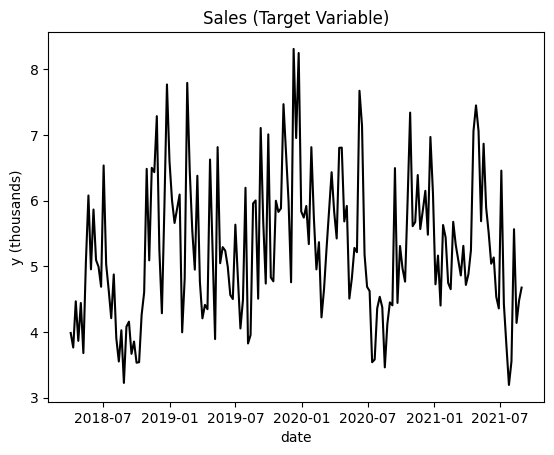

In [10]:
df["intercept"] = 2.0
df["epsilon"] = rng.normal(loc=0.0, scale=0.25, size=n)

amplitude = 1
beta_1 = 3.0
beta_2 = 2.0
betas = [beta_1, beta_2]


df["y"] = amplitude * (
    df["intercept"]
    + df["trend"]
    + df["seasonality"]
    + 1.5 * df["event_1"]
    + 2.5 * df["event_2"]
    + beta_1 * df["x1_adstock_saturated"]
    + beta_2 * df["x2_adstock_saturated"]
    + df["epsilon"]
)

fig, ax = plt.subplots()
sns.lineplot(x="date_week", y="y", color="black", data=df, ax=ax)
ax.set(title="Sales (Target Variable)", xlabel="date", ylabel="y (thousands)");

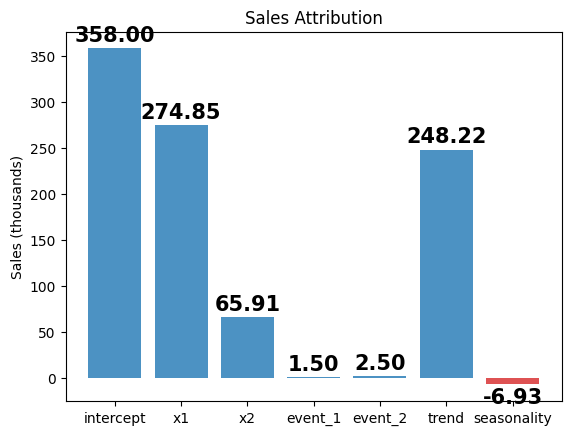

In [11]:
fig, ax = plt.subplots()

contributions = [
    df["intercept"].sum(),
    (beta_1 * df["x1_adstock_saturated"]).sum(),
    (beta_2 * df["x2_adstock_saturated"]).sum(),
    1.5 * df["event_1"].sum(),
    2.5 * df["event_2"].sum(),
    df["trend"].sum(),
    df["seasonality"].sum(),
]

ax.bar(
    ["intercept", "x1", "x2", "event_1", "event_2", "trend", "seasonality"],
    contributions,
    color=["C0" if x >= 0 else "C3" for x in contributions],
    alpha=0.8,
)
ax.bar_label(
    ax.containers[0],
    fmt="{:,.2f}",
    label_type="edge",
    padding=2,
    fontsize=15,
    fontweight="bold",
)
ax.set(title="Sales Attribution", ylabel="Sales (thousands)");

In [12]:
contribution_share_x1: float = (beta_1 * df["x1_adstock_saturated"]).sum() / (
    beta_1 * df["x1_adstock_saturated"] + beta_2 * df["x2_adstock_saturated"]
).sum()

contribution_share_x2: float = (beta_2 * df["x2_adstock_saturated"]).sum() / (
    beta_1 * df["x1_adstock_saturated"] + beta_2 * df["x2_adstock_saturated"]
).sum()

print(f"Contribution Share of x1: {contribution_share_x1:.2f}")
print(f"Contribution Share of x2: {contribution_share_x2:.2f}")

Contribution Share of x1: 0.81
Contribution Share of x2: 0.19


In [13]:
roas_1 = (amplitude * beta_1 * df["x1_adstock_saturated"]).sum() / df["x1"].sum()
roas_2 = (amplitude * beta_2 * df["x2_adstock_saturated"]).sum() / df["x2"].sum()

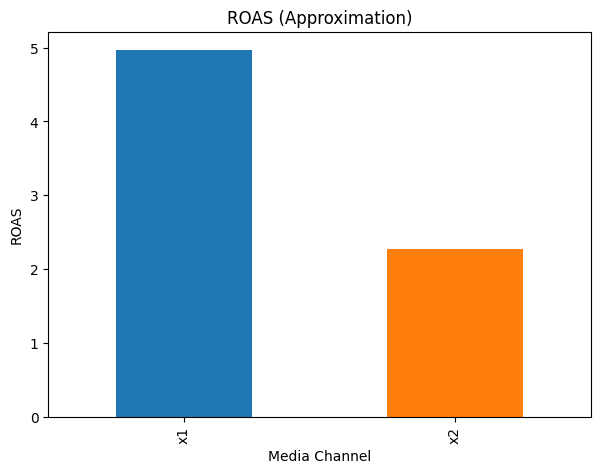

In [14]:
fig, ax = plt.subplots(figsize=(7, 5))
(
    pd.Series(data=[roas_1, roas_2], index=["x1", "x2"]).plot(
        kind="bar", color=["C0", "C1"]
    )
)

ax.set(title="ROAS (Approximation)", xlabel="Media Channel", ylabel="ROAS");

## Data Preprocessing for Model Fitting

Prepare the data for model fitting.

In [15]:

columns_to_keep = [
    "date_week",
    "y",
    "x1",
    "x2",
    "event_1",
    "event_2",
    "dayofyear",
]

data = df[columns_to_keep].copy()

data.head()

,date_week,y,x1,x2,event_1,event_2,dayofyear
0,2018-04-02,3.984662,0.318580,0.0,0.0,0.0,92
1,2018-04-09,3.762872,0.112388,0.0,0.0,0.0,99
2,2018-04-16,4.466967,0.292400,0.0,0.0,0.0,106
3,2018-04-23,3.864219,0.071399,0.0,0.0,0.0,113
4,2018-04-30,4.441625,0.386745,0.0,0.0,0.0,120


In [16]:
# trend feature
data["t"] = range(n)

data.head()

,date_week,y,x1,x2,event_1,event_2,dayofyear,t
0,2018-04-02,3.984662,0.318580,0.0,0.0,0.0,92,0
1,2018-04-09,3.762872,0.112388,0.0,0.0,0.0,99,1
2,2018-04-16,4.466967,0.292400,0.0,0.0,0.0,106,2
3,2018-04-23,3.864219,0.071399,0.0,0.0,0.0,113,3
4,2018-04-30,4.441625,0.386745,0.0,0.0,0.0,120,4


In [17]:
# scale the data
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()
scaled_data = data.copy()
scaled_data['x1_original'] = scaled_data['x1']
scaled_data['x2_original'] = scaled_data['x2']
scaled_data[['y', 'x1', 'x2', 'dayofyear', 't']] = scaler.fit_transform(scaled_data[['y', "x1", "x2", 'dayofyear', "t"]])

In [18]:
import numpy as np

def make_fourier_features(dayofyear, period=365.25, order=3):
    """Return sine and cosine Fourier terms up to the given order."""
    x = 2 * np.pi * dayofyear[:, None] / period
    terms = [np.sin(k * x) for k in range(1, order + 1)] + \
            [np.cos(k * x) for k in range(1, order + 1)]
    return np.hstack(terms)

# Example usage
fourier_terms = make_fourier_features(data['dayofyear'].values, order=2)

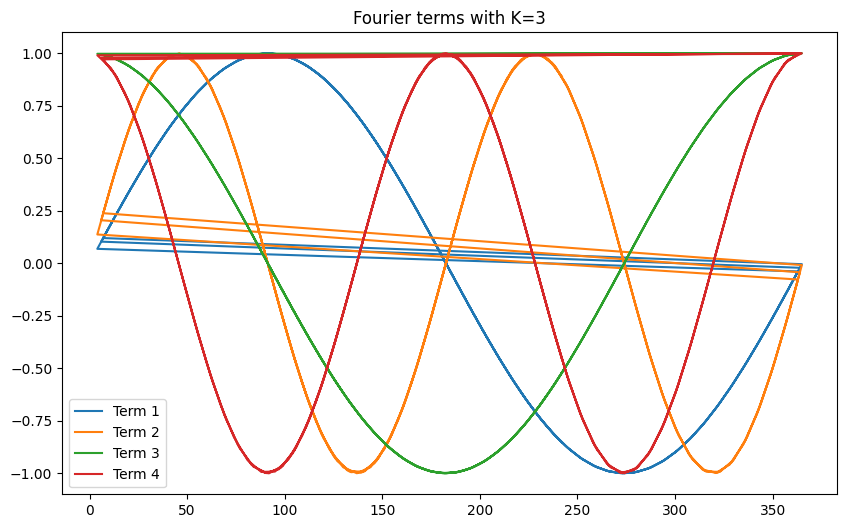

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(fourier_terms.shape[1]):
    ax.plot(data['dayofyear'], fourier_terms[:, i], label=f"Term {i+1}")
ax.legend()
ax.set_title(f"Fourier terms with K={3}")
plt.show()

In [20]:
# add fourier terms to scaled_data
scaled_data = pd.concat([scaled_data, pd.DataFrame(fourier_terms, columns=[f"fourier_{i}" for i in range(fourier_terms.shape[1])])], axis=1)
scaled_data.head()

,date_week,y,x1,x2,event_1,event_2,dayofyear,t,x1_original,x2_original,fourier_0,fourier_1,fourier_2,fourier_3
0,2018-04-02,0.479363,0.319648,0.0,0.0,0.0,0.252055,0.000000,0.318580,0.0,0.999930,-0.023651,-0.011826,-0.999720
1,2018-04-09,0.452681,0.112765,0.0,0.0,0.0,0.271233,0.005618,0.112388,0.0,0.991269,-0.261414,-0.131859,-0.965227
2,2018-04-16,0.537386,0.293381,0.0,0.0,0.0,0.290411,0.011236,0.292400,0.0,0.968251,-0.484089,-0.249981,-0.875019
3,2018-04-23,0.464874,0.071638,0.0,0.0,0.0,0.309589,0.016854,0.071399,0.0,0.931210,-0.678820,-0.364483,-0.734304
4,2018-04-30,0.534337,0.388042,0.0,0.0,0.0,0.328767,0.022472,0.386745,0.0,0.880683,-0.834370,-0.473706,-0.551205


## Fit Model

In [21]:
from pymc_marketing.mmm import GeometricAdstock, LogisticSaturation

def forward_pass(x, adstock_alpha, saturation_lam, saturation_beta, l_max=8):
    """
    Forward pass using GeometricAdstock and LogisticSaturation classes
    with PyMC variables.
    """
    # Apply adstock using the class method
    x_adstocked = GeometricAdstock(l_max=l_max).function(x, alpha=adstock_alpha)

    # Apply saturation using the class method
    x_saturated = LogisticSaturation().function(x=x_adstocked, lam=saturation_lam, beta=saturation_beta)

    return x_saturated


In [22]:
import pymc as pm

with pm.Model() as bm:

    # ----------------------
    # Priors
    # ----------------------
    alpha = pm.Normal("alpha", 0.5, sigma=0.2)          # intercept
    beta_t = pm.HalfNormal("beta_t", sigma=0.02)        # trend slope

    # Media spend coefficients
    beta_x1 = pm.HalfNormal("beta_x1", sigma=0.5)
    beta_x2 = pm.HalfNormal("beta_x2", sigma=0.5)

    # Fourier terms
    beta_fourier = pm.Laplace("beta_fourier", mu=0.0, b=0.2, shape=fourier_terms.shape[1])

    # Control events
    gamma_control1 = pm.Normal("gamma_control1", 0, 0.05)
    gamma_control2 = pm.Normal("gamma_control2", 0, 0.05)

    # Noise
    sigma = pm.HalfNormal("sigma", sigma=2)

    # Adstock and saturation priors
    adstock_alpha1 = pm.Beta("adstock_alpha1", alpha=2, beta=2)
    saturation_lam1 = pm.Gamma("saturation_lam1", alpha=3, beta=1)
    saturation_beta1 = pm.HalfNormal("saturation_beta1", sigma=2)

    adstock_alpha2 = pm.Beta("adstock_alpha2", alpha=2, beta=2)
    saturation_lam2 = pm.Gamma("saturation_lam2", alpha=3, beta=1)
    saturation_beta2 = pm.HalfNormal("saturation_beta2", sigma=2)

    # ----------------------
    # Forward pass and Deterministic contributions
    # ----------------------
    x1_transformed = pm.Deterministic(
        "x1_transformed",
        forward_pass(scaled_data['x1'].values, adstock_alpha1, saturation_lam1, saturation_beta1)
    )

    x2_transformed = pm.Deterministic(
        "x2_transformed",
        forward_pass(scaled_data['x2'].values, adstock_alpha2, saturation_lam2, saturation_beta2)
    )

    channel1_contribution = pm.Deterministic("channel1_contribution", beta_x1 * x1_transformed)
    channel2_contribution = pm.Deterministic("channel2_contribution", beta_x2 * x2_transformed)
    fourier_contribution = pm.Deterministic("fourier_contribution", pm.math.dot(fourier_terms, beta_fourier))
    trend_contribution = pm.Deterministic("trend_contribution", beta_t * scaled_data['t'].values)
    control1_contribution = pm.Deterministic("control1_contribution", gamma_control1 * scaled_data['event_1'].values)
    control2_contribution = pm.Deterministic("control2_contribution", gamma_control2 * scaled_data['event_2'].values)

    # ----------------------
    # Expected value of outcome
    # ----------------------
    mu = pm.Deterministic(
        "mu",
        alpha
        + channel1_contribution
        + channel2_contribution
        + fourier_contribution
        + trend_contribution
        + control1_contribution
        + control2_contribution
    )

    # Likelihood
    Ylikelihood = pm.Normal("Ylikelihood", mu, sigma, observed=scaled_data['y'].values)

    # Prior predictive check
    idata = pm.sample_prior_predictive(samples=500, random_seed=rng)


Shape of y_prior before squeeze: (1, 500, 179)
Shape of y_prior after squeeze: (500, 179)


/tmp/ipython-input-4071725776.py:9: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_94 = az.hdi(y_prior_squeezed, hdi_prob=0.94)
/tmp/ipython-input-4071725776.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_50 = az.hdi(y_prior_squeezed, hdi_prob=0.50)


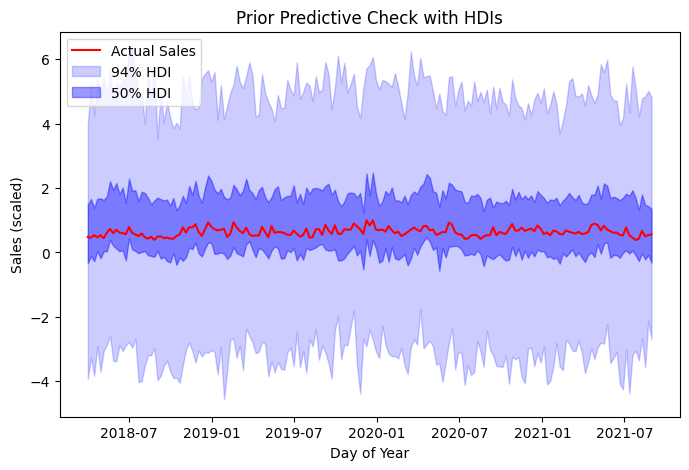

In [23]:
# Extract predictions
y_prior = idata.prior_predictive["Ylikelihood"].values
print(f"Shape of y_prior before squeeze: {y_prior.shape}")

# Remove the extra dimension of size 1
y_prior_squeezed = np.squeeze(y_prior)
print(f"Shape of y_prior after squeeze: {y_prior_squeezed.shape}")

hdi_94 = az.hdi(y_prior_squeezed, hdi_prob=0.94)
hdi_50 = az.hdi(y_prior_squeezed, hdi_prob=0.50)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(scaled_data['date_week'].values, scaled_data['y'], color="red", label="Actual Sales")
plt.fill_between(scaled_data['date_week'].values, hdi_94[:, 0], hdi_94[:, 1], color="blue", alpha=0.2, label="94% HDI")
plt.fill_between(scaled_data['date_week'].values, hdi_50[:, 0], hdi_50[:, 1], color="blue", alpha=0.4, label="50% HDI")
plt.title("Prior Predictive Check with HDIs")
plt.xlabel("Day of Year")
plt.ylabel("Sales (scaled)")
plt.legend()
plt.show()

## Model Diagnostics

Output()

/usr/local/lib/python3.12/dist-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (23), generating only 20 plots
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/usr/local/lib/python3.12/dist-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/usr/local/lib/python3.12/dist-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


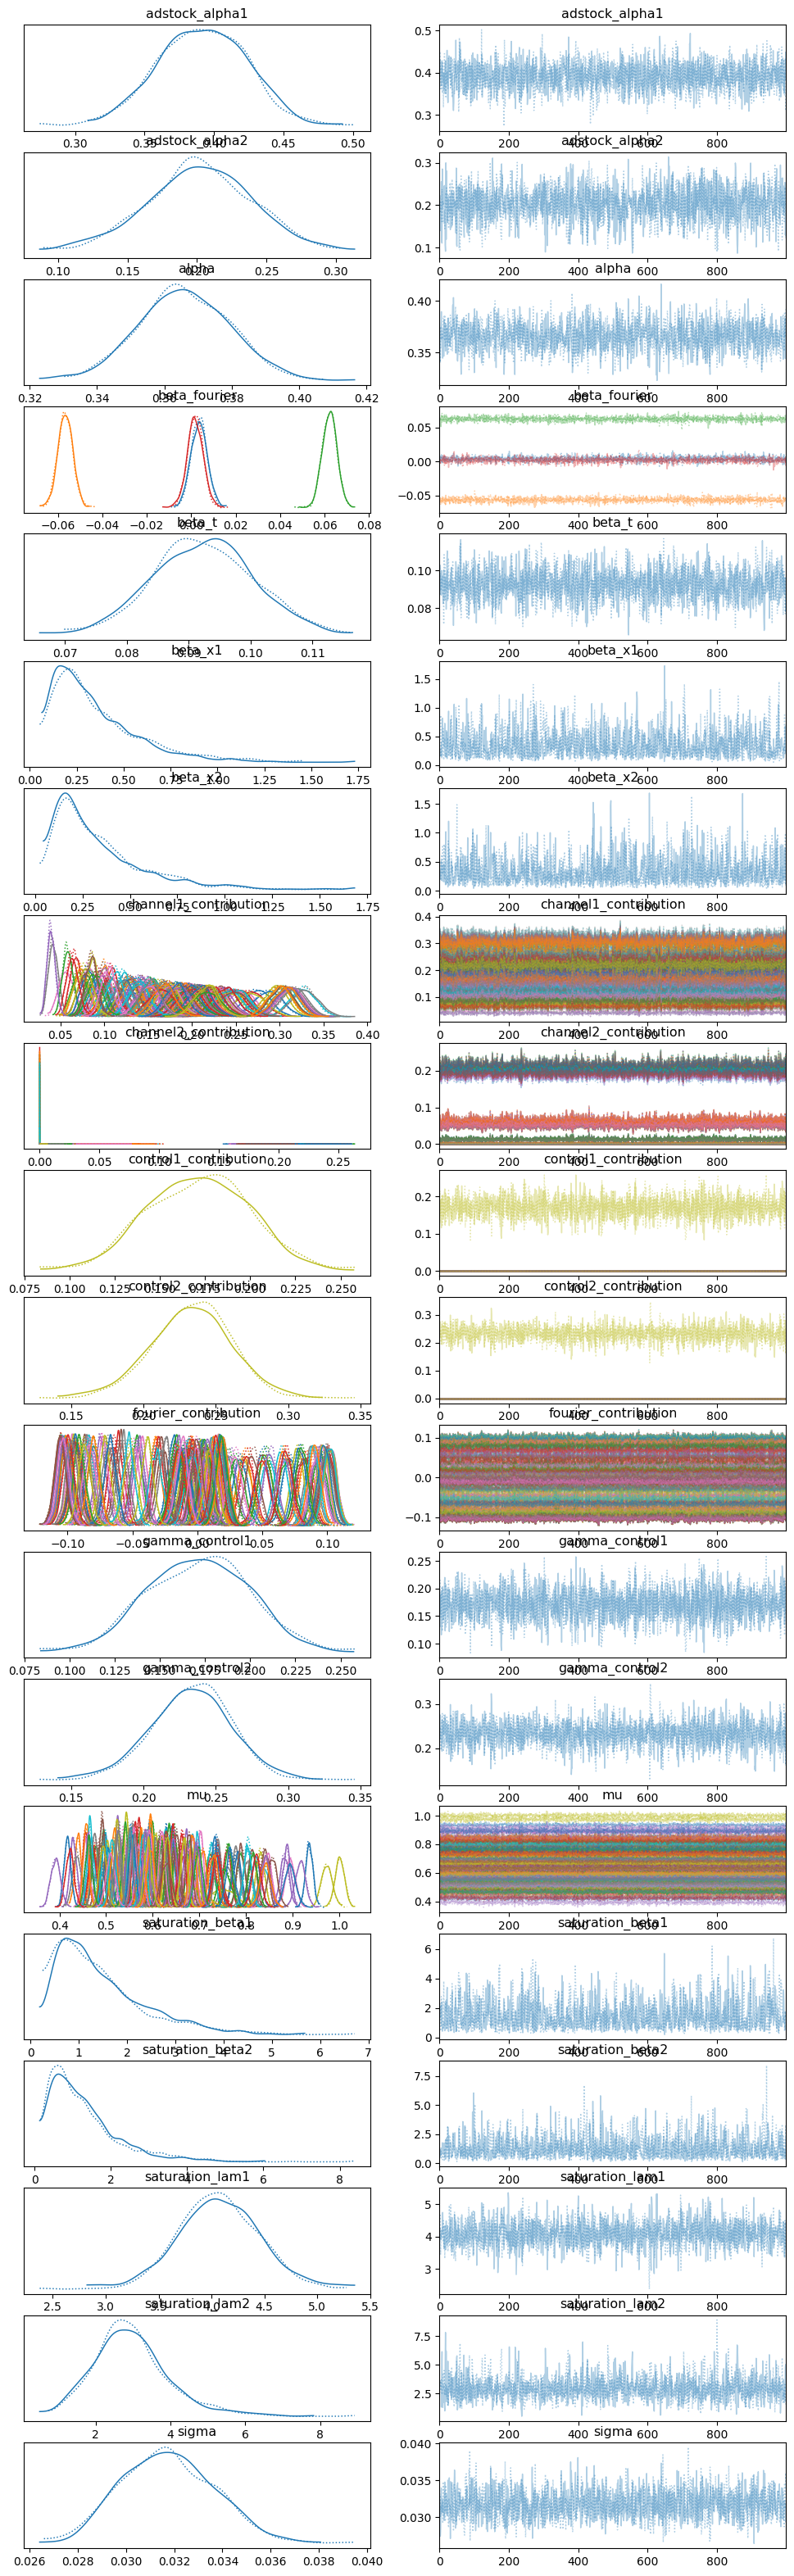

In [24]:
with bm:
    idata.extend(pm.sample(1000, tune=1000, random_seed=rng))

az.plot_trace(idata);

In [25]:
with bm:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=rng)

Output()

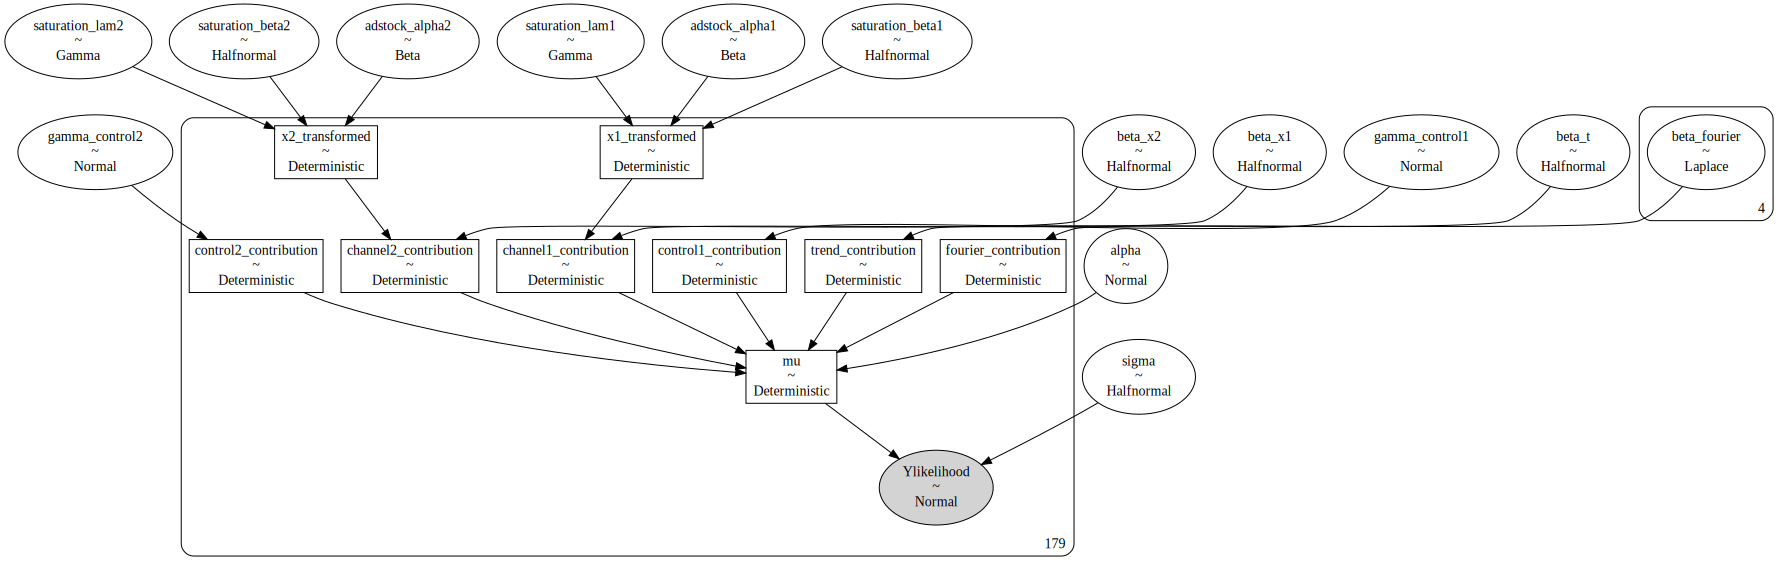

In [26]:
pm.model_to_graphviz(bm)

In [27]:
idata['sample_stats']['diverging'].sum().item()

0

Shape of y_posterior before squeeze: (2, 1000, 179)
Shape of y_posterior after squeeze: (2, 1000, 179)


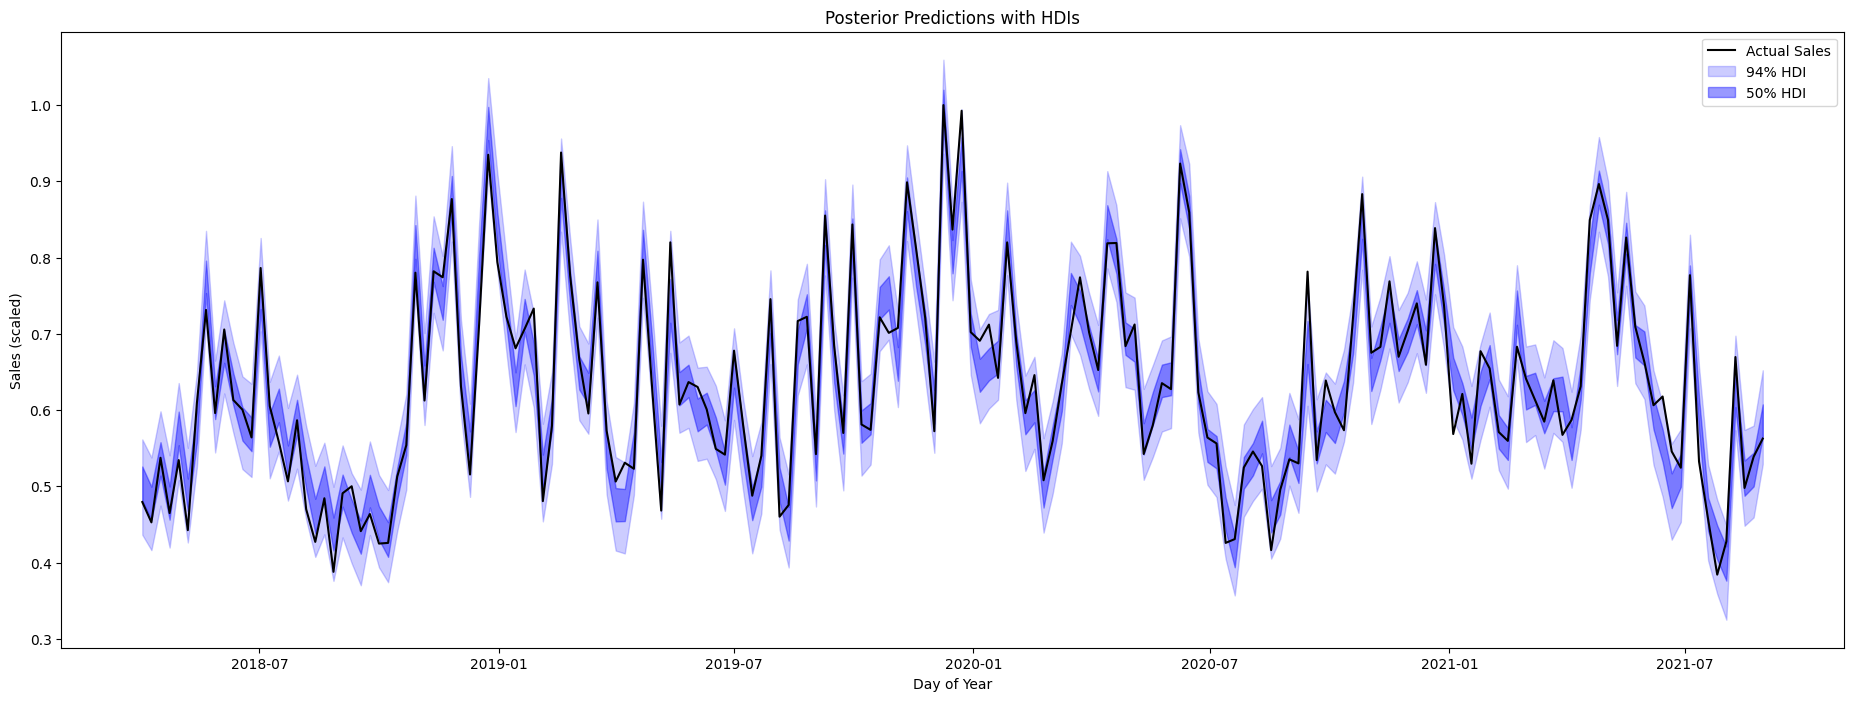

In [28]:
# Extract predictions
y_posterior = idata.posterior_predictive["Ylikelihood"].values
print(f"Shape of y_posterior before squeeze: {y_posterior.shape}")

# Remove the extra dimension of size 1
y_posterior_squeezed = np.squeeze(y_posterior)
print(f"Shape of y_posterior after squeeze: {y_posterior_squeezed.shape}")

hdi_94 = az.hdi(y_posterior_squeezed, hdi_prob=0.94)
hdi_50 = az.hdi(y_posterior_squeezed, hdi_prob=0.50)

# Plot
plt.figure(figsize=(23, 8))
plt.plot(scaled_data['date_week'].values, scaled_data['y'], color="black", label="Actual Sales")
plt.fill_between(scaled_data['date_week'].values, hdi_94[:, 0], hdi_94[:, 1], color="blue", alpha=0.2, label="94% HDI")
plt.fill_between(scaled_data['date_week'].values, hdi_50[:, 0], hdi_50[:, 1], color="blue", alpha=0.4, label="50% HDI")
plt.title("Posterior Predictions with HDIs")
plt.xlabel("Day of Year")
plt.ylabel("Sales (scaled)")
plt.legend()
plt.show()

Fit was good.

## Model Parameter Recovery

Let's see if we recovered the model parameters.

In [29]:
from typing import Any

def plot_channel_parameter(idata, param_name: str, **plt_kwargs: Any) -> plt.Figure:
    """Plot the posterior distribution of a specific parameter for each channel.

    Parameters
    ----------
    idata : az.InferenceData
        The inference data containing the posterior samples.
    channel_columns : list[str]
        A list of strings representing the names of the media channels.
    param_name : str
        The name of the parameter to plot.
    **plt_kwargs : Any
        Additional keyword arguments to pass to the `plt.subplots` function.

    Returns
    -------
    plt.Figure
        The matplotlib Figure object containing the plot.

    Raises
    ------
    ValueError
        If the specified parameter name is invalid or not found in the inference data.

    """
    if param_name not in idata.posterior.data_vars:
        raise ValueError(
            f"Invalid parameter name: {param_name}. Choose from {list(idata.posterior.data_vars)}"
        )

    param_samples_df = pd.DataFrame(
        data=az.extract(data=idata, var_names=[param_name]).T,
    )

    fig, ax = plt.subplots(**plt_kwargs)
    sns.violinplot(data=param_samples_df, orient="h", ax=ax)
    ax.set(
        title=f"Posterior Distribution: {param_name} Parameter",
        xlabel=param_name,
        ylabel="channel",
    )
    return fig

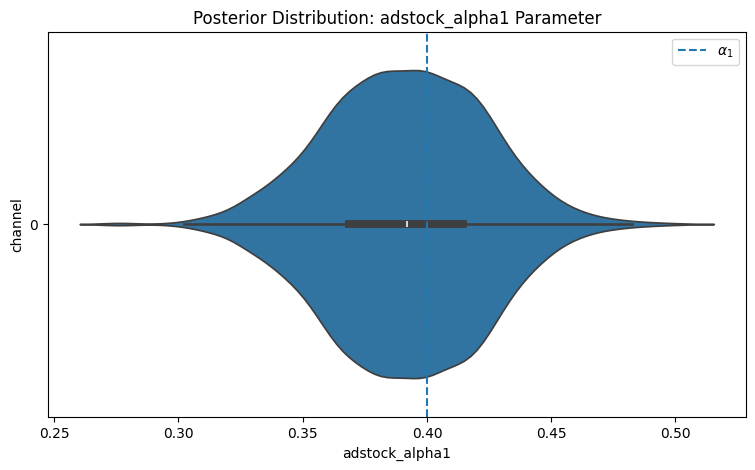

In [30]:
fig = plot_channel_parameter(idata, param_name="adstock_alpha1", figsize=(9, 5))
ax = fig.axes[0]
ax.axvline(x=alpha1, color="C0", linestyle="--", label=r"$\alpha_1$")
ax.legend(loc="upper right");

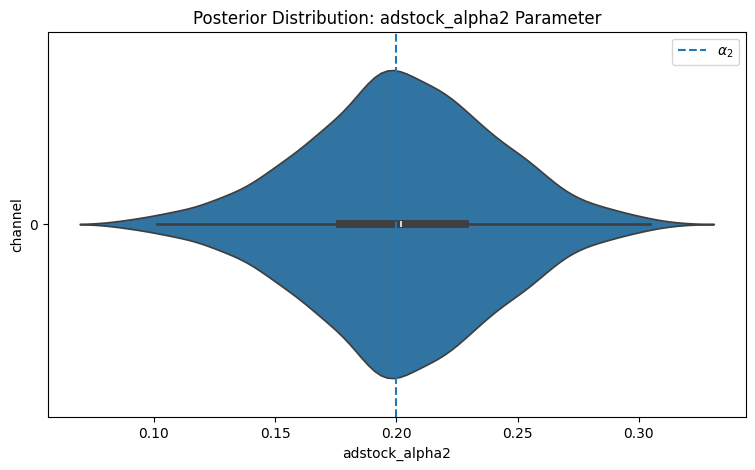

In [31]:
fig = plot_channel_parameter(idata, param_name="adstock_alpha2", figsize=(9, 5))
ax = fig.axes[0]
ax.axvline(x=alpha2, color="C0", linestyle="--", label=r"$\alpha_2$")
ax.legend(loc="upper right");

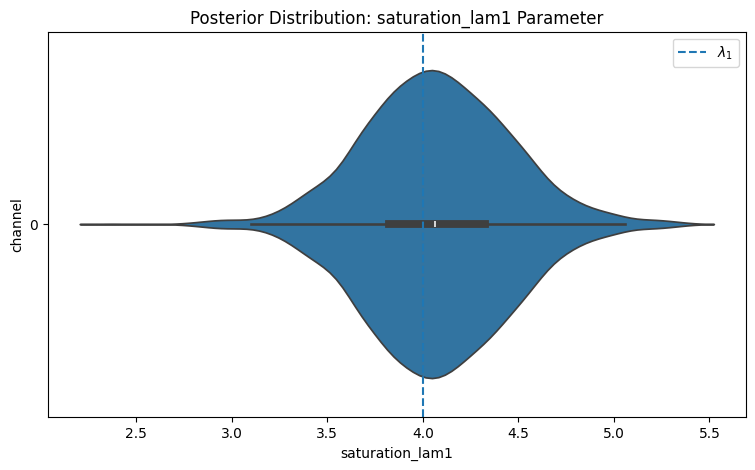

In [32]:
fig = plot_channel_parameter(idata, param_name="saturation_lam1", figsize=(9, 5))
ax = fig.axes[0]
ax.axvline(x=lam1, color="C0", linestyle="--", label=r"$\lambda_1$")
ax.legend(loc="upper right");

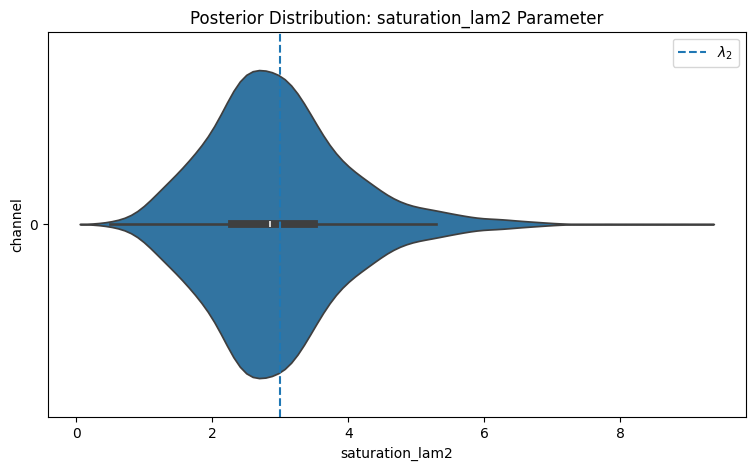

In [33]:
fig = plot_channel_parameter(idata, param_name="saturation_lam2", figsize=(9, 5))
ax = fig.axes[0]
ax.axvline(x=lam2, color="C0", linestyle="--", label=r"$\lambda_2$")
ax.legend(loc="upper right");

## Contribution Recovery

Great, how about contributions parameters?

In [34]:
flat = idata["posterior"]["channel1_contribution"].data.flatten()
channel1_orig = flat*scaler.max_abs_[0]
channel1_orig = channel1_orig.reshape(idata["posterior"]["channel1_contribution"].shape)

In [35]:
flat = idata["posterior"]["channel2_contribution"].data.flatten()
channel2_orig = flat*scaler.max_abs_[0]
channel2_orig = channel2_orig.reshape(idata["posterior"]["channel2_contribution"].shape)


In [36]:
# sum over date axis (axis=2), producing (chain, draw)
ch1 = xr.DataArray(channel1_orig.sum(axis=2), dims=["chain", "draw"])
ch2 = xr.DataArray(channel2_orig.sum(axis=2), dims=["chain", "draw"])

# get total contribution
total_contribution = ch1 + ch2

In [37]:
ch1_share = ch1 / total_contribution
ch2_share = ch2 / total_contribution

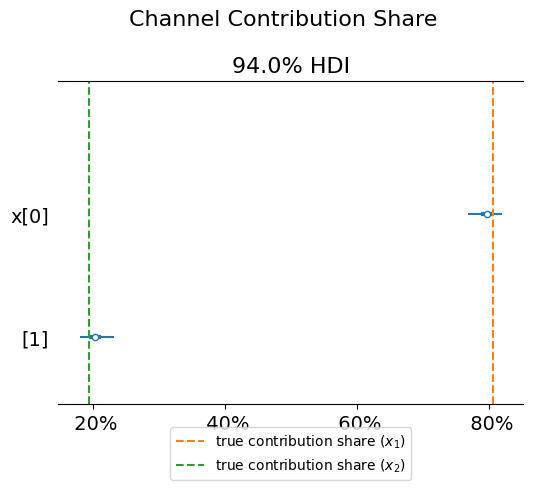

In [38]:
import matplotlib.ticker as mtick

# stack chain and draw into one dimension
channel_contrib = xr.concat([ch1_share, ch2_share], dim="channel")

ax, *_ = az.plot_forest(channel_contrib, combined=True, hdi_prob=.94)
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f"{y: 0.0%}"))
fig: plt.Figure = plt.gcf()
fig.suptitle("Channel Contribution Share", fontsize=16, y=1.05)
ax = fig.axes[0]
ax.axvline(
    x=contribution_share_x1,
    color="C1",
    linestyle="--",
    label="true contribution share ($x_1$)",
)
ax.axvline(
    x=contribution_share_x2,
    color="C2",
    linestyle="--",
    label="true contribution share ($x_2$)",
)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=1);

## ROAS recovery

In [39]:
scaler.max_abs_[0]

np.float64(8.31240754439164)

Text(0.5, 1.06, 'ROAS Posterior Distributions')

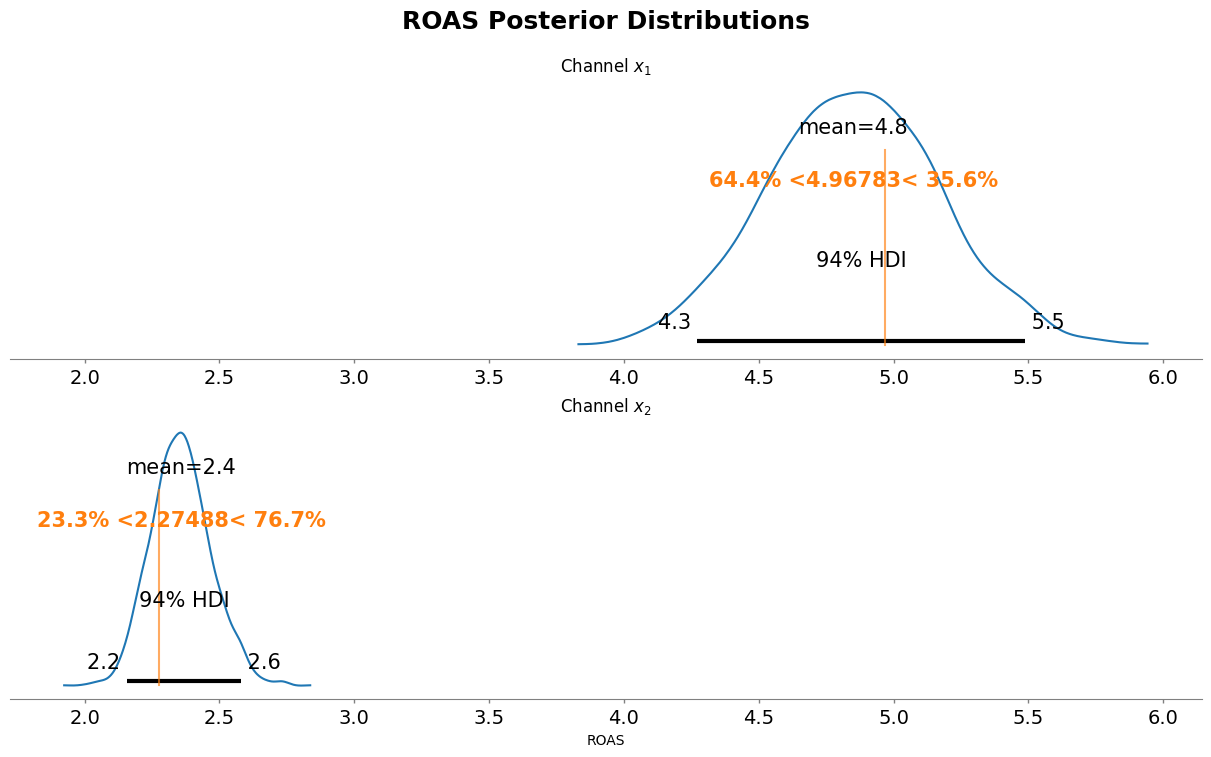

In [40]:
# sum over date axis (axis=2), producing (chain, draw)
roas_ch1 = xr.DataArray(channel1_orig.sum(axis=2), dims=["chain", "draw"])
roas_ch2 = xr.DataArray(channel2_orig.sum(axis=2), dims=["chain", "draw"])

# divide by total spend
spend_sum = data[["x1", "x2"]].sum().to_numpy()
roas_ch1 = roas_ch1 / spend_sum[0]
roas_ch2 = roas_ch2 / spend_sum[1]

# stack into one DataArray with "channel" dimension so arviz plots nicely
roas_samples = xr.concat(
    [roas_ch1, roas_ch2],
    dim=xr.IndexVariable("channel", ["x1", "x2"]))

# plot
fig, axes = plt.subplots(
    nrows=2, ncols=1, figsize=(12, 7), sharex=True, sharey=False, layout="constrained"
)
az.plot_posterior(
    roas_samples,
    ref_val=[roas_1, roas_2],  # your benchmark ROAS
    ax=axes,
)
axes[0].set(title="Channel $x_{1}$")
axes[1].set(title="Channel $x_{2}$", xlabel="ROAS")
fig.suptitle("ROAS Posterior Distributions", fontsize=18, fontweight="bold", y=1.06)
